## Data Generator

In [1]:
import sys
print(sys.version)

2.7.13 |Anaconda 4.4.0 (64-bit)| (default, Dec 20 2016, 23:09:15) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import numpy as np
from utils.parse_input import load_data    # Data handler for LISA dataset

x_train, y_train = load_data('data/training.txt')
labels           = np.unique(y_train[:,1])
num_classes      = len(labels)  # Count number of classes in the dataset

print("Train: {} samples\nNumber of classes: {}".format(len(x_train),num_classes))

Number of ground truth boxes: 3672 boxes
Train: 3672 samples
Number of classes: 31


In [15]:
import pandas as pd

categories = np.unique(y_train[:, 1])
label_map  = pd.factorize(categories)[0]
print(categories)
print(label_map)

['addedLane' 'bicyclesMayUseFullLane' 'curveLeft' 'curveRight' 'doNotEnter'
 'intersection' 'intersectionLaneControl' 'keepRight' 'laneEnds'
 'leftAndUTurnControl' 'merge' 'noLeftAndUTurn' 'noParking' 'noRightTurn'
 'noUTurn' 'pedestrianCrossing' 'school' 'signalAhead' 'speedBumpsAhead'
 'speedLimit15' 'speedLimit25' 'speedLimit30' 'speedLimit35' 'speedLimit40'
 'speedLimit45' 'speedLimit50' 'speedLimit60' 'stop' 'stopAhead'
 'yieldAhead' 'yieldToPedestrian']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


In [16]:
from utils.data_generator import flow_from_list
from cfg import *

data_gen   = flow_from_list(x_train, y_train, batch_size=4, scaling_factor=5, augment_data=True)

In [56]:
images, labels  = data_gen.next()

print("Images shape {}".format(images[0].shape))
GRID_W = np.shape(images)[2]/ SHRINK_FACTOR
GRID_H = np.shape(images)[1]/ SHRINK_FACTOR

labels = labels.reshape([-1, GRID_H, GRID_W, N_ANCHORS, N_CLASSES+5])
print("List of images : {}".format(np.shape(images)))
print("List of labels : {}\n".format(np.shape(labels)))

Images shape (480, 640, 3)
List of images : (4, 480, 640, 3)
List of labels : (4, 15, 20, 5, 36)



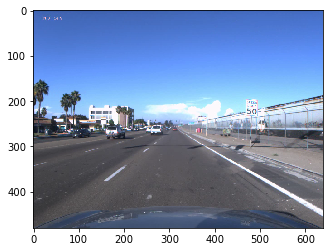

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(images[0])

[ 0.75390625  0.44895833  0.046875    0.08125     1.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          0.          0.          0.
  0.        ]


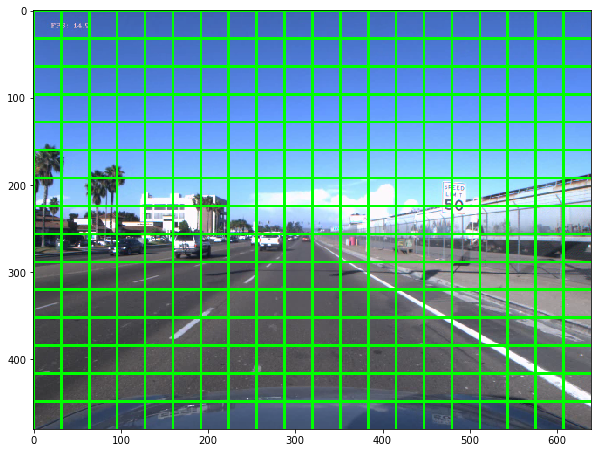

In [65]:
import cv2
img = images[0]
height, width, c = img.shape

shrink_factor = 32
grid_w = list(range(width/shrink_factor))
grid_h = list(range(height/shrink_factor))
center = 0
# Plot grid map
for r in grid_w:
    img = cv2.line(img,(r*shrink_factor, 0), (r*shrink_factor, height), color=(0, 1, 0), thickness=2)
    
for h in grid_h:
    img = cv2.line(img,(0, h*shrink_factor), (width, h*shrink_factor), color=(0, 1, 0), thickness=2)
    
plt.figure(figsize=(10, 10))
plt.imshow(img)
print(labels[0][6][15][0])

(0, 448)


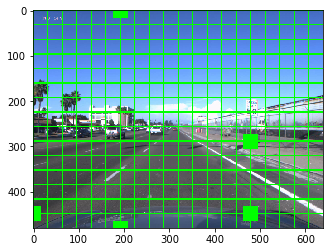

In [71]:
# Test if it is in correct cell, this case, traffic sign is located in cell r=6, c=17
a = labels[0][labels[0] > 0.]

center = (height - 15*shrink_factor, width - 6*shrink_factor)
print(center)
p1 = (center[0] - 16, center[1] - 16)
p2 = (center[0] + 16, center[1] + 16)

result = cv2.rectangle(img, p1, p2, (0, 1, 0), thickness=cv2.FILLED)

plt.imshow(result)

In [ ]:
from utils.image_handler import draw_boxes
from utils.box import Box
import matplotlib.pyplot as plt
%matplotlib inline

label_map = np.unique(y_train[:, 1])
row, col = 2, 2
fg, a    = plt.subplots(row, col, figsize =(20, 15))
fg.tight_layout()
height, width, _ = images[0].shape
print("Image size:", images[0].shape)
i        = 0
for r in range(row):
    for c in range(col):
        tmp = labels[i][labels[i] > 0.]
        if len(tmp[0:4]) == 0 :
            bbox = Box(0,0,0,0)
        else:
            xc, yc, w ,h = tmp[tmp > 0][0:4]
            bbox = Box(xc, yc, w ,h)
            print(bbox)
        bbox.to_abs_size((width, height))
        opencv_box = bbox.to_opencv_format()
        print(opencv_box)
        a[r, c].axis('off')
        a[r, c].imshow(draw_boxes(images[i], opencv_box, color=(255, 255, 255), thickness=2))
        a[r, c].set_title(str(i))
        i +=1